Epoch 1, Train Loss: 0.4204, Val Loss: 0.2379, Train Acc: 0.8649, Val Acc: 0.9285
Epoch 2, Train Loss: 0.2446, Val Loss: 0.2373, Train Acc: 0.9262, Val Acc: 0.9330
Epoch 3, Train Loss: 0.2326, Val Loss: 0.2000, Train Acc: 0.9300, Val Acc: 0.9412
Epoch 4, Train Loss: 0.2295, Val Loss: 0.2298, Train Acc: 0.9319, Val Acc: 0.9313
Epoch 5, Train Loss: 0.2310, Val Loss: 0.2072, Train Acc: 0.9306, Val Acc: 0.9408
Epoch 6, Train Loss: 0.2129, Val Loss: 0.2304, Train Acc: 0.9356, Val Acc: 0.9327
Early stopping at epoch 6


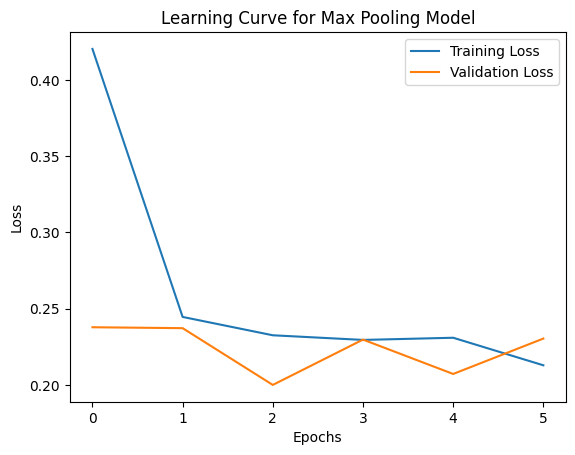

Test Loss: 0.2085, Test Accuracy: 0.9335


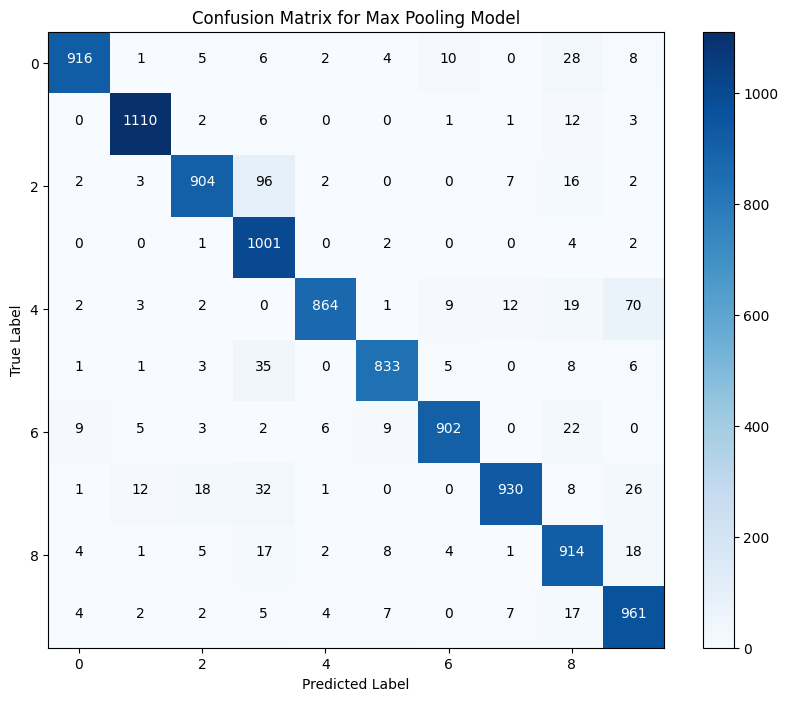

In [13]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split training data into train and validation sets
train_data, val_data = random_split(train_data, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = DataLoader(val_data, batch_size=50, shuffle=False)
test_loader = DataLoader(test_data, batch_size=50, shuffle=False)

# Define the CNN model with Max Pooling
class CNNWithMaxPool(nn.Module):
    def __init__(self):
        super(CNNWithMaxPool, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)  # Max pooling with stride 3
        self.conv2 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=1)
        
        # Calculate the input dimension for the fully connected layer
        # by passing a dummy tensor through the conv and pooling layers
        dummy_input = torch.zeros(1, 1, 28, 28)
        dummy_output = self.forward_conv_layers(dummy_input)
        self.fc_input_dim = dummy_output.numel()

        self.fc = nn.Linear(self.fc_input_dim, 10)

    def forward_conv_layers(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        return x
    
    def forward(self, x):
        x = self.forward_conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x  # Return logits directly

# Initialize model, optimizer, and loss function
model = CNNWithMaxPool()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
criterion = nn.CrossEntropyLoss()

# Training function
def train(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for batch, labels in loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch.size(0)
        correct += (output.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch, labels in loader:
            output = model(batch)
            loss = criterion(output, labels)
            total_loss += loss.item() * batch.size(0)
            correct += (output.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Optional early stopping
patience = 3  # Number of epochs to wait for improvement before stopping
trigger_times = 0
best_val_loss = float('inf')

# Train the model
epochs = 20
train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    scheduler.step()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plot learning curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve for Max Pooling Model')
plt.show()

# Evaluate on test set and display confusion matrix
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Confusion matrix
all_preds = []
all_labels = []
with torch.no_grad():
    for batch, labels in test_loader:
        output = model(batch)
        preds = output.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix for Max Pooling Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", 
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

"""
The kernels in the convolutional layers of the max-pooling model seem to be learning to recognize important features in the MNIST digit images, like edges, corners, and basic shapes. 
The training and validation losses decrease at first and then level off, showing that the model is learning useful patterns during the early epochs, which is a good sign. 
The model stops early at epoch 6 with a good validation accuracy of about 93%, suggesting that the features it has learned are effective in distinguishing between different digits. 
The max-pooling with a stride of 3 likely helps capture the main features of the digits, like the broad strokes, while reducing the image size to avoid overfitting and speed up training. 
Looking at the confusion matrix and test accuracy, we can see which digits the model has trouble with. 
The model seems to learn general features (like vertical and horizontal lines for digits like "1" and "7"), but it may still find it difficult to tell apart similar digits like "3" and "5" or "8" and "9". 
This is common in early convolutional networks, where distinguishing between similar-looking digits is still a challenge. 
In conclusion, the kernels seem to learn basic features like edges and shapes, which helps with classifying digits, but some improvement is needed to better tell apart similar digits.
"""

